# Notebook 3 - Visualitzacions i Conclusions

Aquest notebook genera visualitzacions avançades per interpretar els clústers de jugadors i presenta les conclusions finals del projecte. Inclou:

- Visualitzacions comparatives entre clústers (radar charts, box plots, barres)
- Reducció dimensional amb t-SNE per visualització 2D/3D
- Heatmaps de zones de tir per clúster amb dades de MongoDB
- Top jugadors per clúster segons rendiment
- Conclusions, limitacions i aplicacions pràctiques

## 1. Imports i Càrrega de Dades

Importa les llibreries necessàries (pandas, numpy, matplotlib, seaborn, sklearn, pymongo) i configura l'entorn de visualització. Prepara les eines per a reducció dimensional (t-SNE) i connexió amb MongoDB per a dades de tirs.

In [1]:
import os
# Prevenir errors de joblib en Windows
os.environ['LOKY_MAX_CPU_COUNT'] = '1'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import pymongo
from pymongo import MongoClient
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

Carrega els fitxers CSV amb dades de clústers (players_clustered.csv, player_clusters.csv, players_aggregated.csv, players_features_scaled.csv). Combina la informació de jugadors amb els clústers assignats i crea el directori per guardar figures.

In [2]:
# Carregar dades amb clústers
df_clustered = pd.read_csv('../data/processed/players_clustered.csv')
df_player_info = pd.read_csv('../data/processed/player_clusters.csv')
df_agg = pd.read_csv('../data/processed/players_aggregated.csv')
df_scaled = pd.read_csv('../data/processed/players_features_scaled.csv')

# Afegir player_feb_id i player_name al df_clustered
df_clustered = pd.concat([df_player_info[['player_feb_id', 'player_name']], df_clustered], axis=1)

# Crear directori figures
import os
os.makedirs('../reports/figures', exist_ok=True)

print(f"Dades carregades")
print(f"  Jugadors: {len(df_clustered)}")
print(f"  Clústers: {df_clustered['cluster'].nunique()}")
print(f"  Columnes: {list(df_clustered.columns)}")

Dades carregades
  Jugadors: 1816
  Clústers: 5
  Columnes: ['player_feb_id', 'player_name', 'pts_per36', 'ast_per36', 'trb_per36', 'stl_per36', 'blk_per36', 'tov_per36', 'fga_per36', '3pa_per36', '2pa_per36', 'fg2_pct', 'fg3_pct', 'ft_pct', 'usage_2p', 'usage_3p', 'oer', 'der', 'true_shooting_pct', 'orb', 'drb', 'pf', 'cluster', 'cluster_name']


## 2. Visualitzacions Comparatives entre Clústers

Prepara visualitzacions per comparar els diferents clústers de jugadors: radar charts (perfils multi-estadística), box plots (distribucions per variable) i gràfics de barres (comparació de mitjanes). Permet identificar punts forts i febles de cada grup.

### 2.1. Radar Charts (Gràfics de Spider)

Genera radar charts per visualitzar el perfil mitjà de cada clúster en múltiples estadístiques simultàniament. Les dades es normalitzen entre 0 i 1 per permetre comparació directa entre variables amb diferents escales.

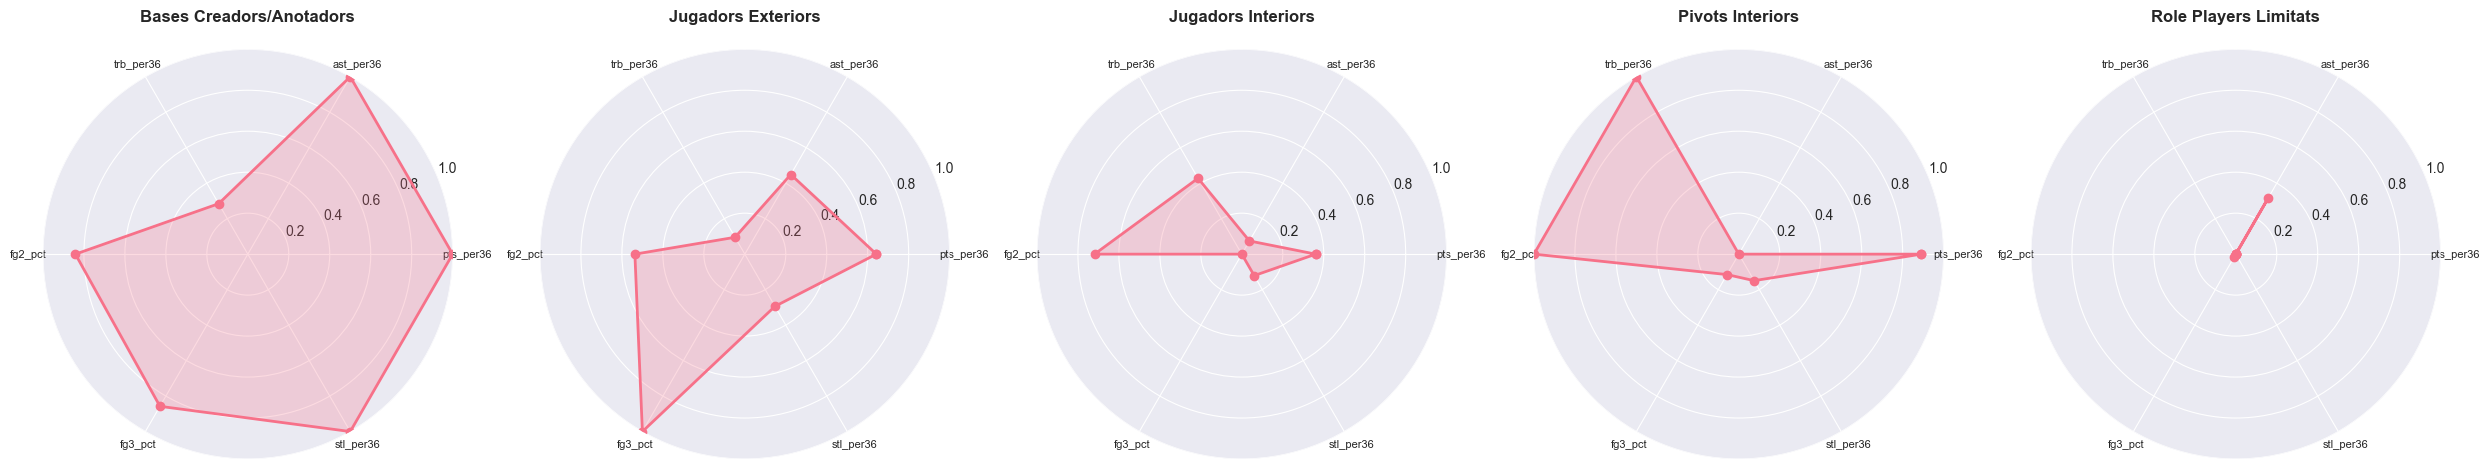

In [3]:
from math import pi

def create_radar_chart(data, categories, cluster_name, ax):
    """Crea un radar chart per un clúster"""
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    data = data + data[:1]
    angles += angles[:1]
    
    ax.plot(angles, data, 'o-', linewidth=2)
    ax.fill(angles, data, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=8)
    ax.set_ylim(0, 1)
    ax.set_title(cluster_name, size=12, fontweight='bold', pad=20)
    ax.grid(True)

# Normalitzar dades per radar charts (0-1)
stats_for_radar = ['pts_per36', 'ast_per36', 'trb_per36', 'fg2_pct', 'fg3_pct', 'stl_per36']
df_radar = df_clustered.groupby('cluster_name')[stats_for_radar].mean()

# Normalitzar entre 0 i 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_radar_norm = pd.DataFrame(
    scaler.fit_transform(df_radar),
    columns=df_radar.columns,
    index=df_radar.index
)

# Crear radar charts
num_clusters = len(df_radar_norm)
fig, axes = plt.subplots(1, num_clusters, figsize=(5*num_clusters, 5), 
                        subplot_kw=dict(projection='polar'))

if num_clusters == 1:
    axes = [axes]

for idx, (cluster_name, row) in enumerate(df_radar_norm.iterrows()):
    create_radar_chart(row.values.tolist(), stats_for_radar, cluster_name, axes[idx])

plt.tight_layout()
plt.savefig('../reports/figures/radar_charts.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.2. Gràfic Circular de Distribució de Clústers

Crea un gràfic circular (pie chart) que mostra la distribució percentual de jugadors per clúster. Permet veure ràpidament quins perfils són més freqüents a la lliga.

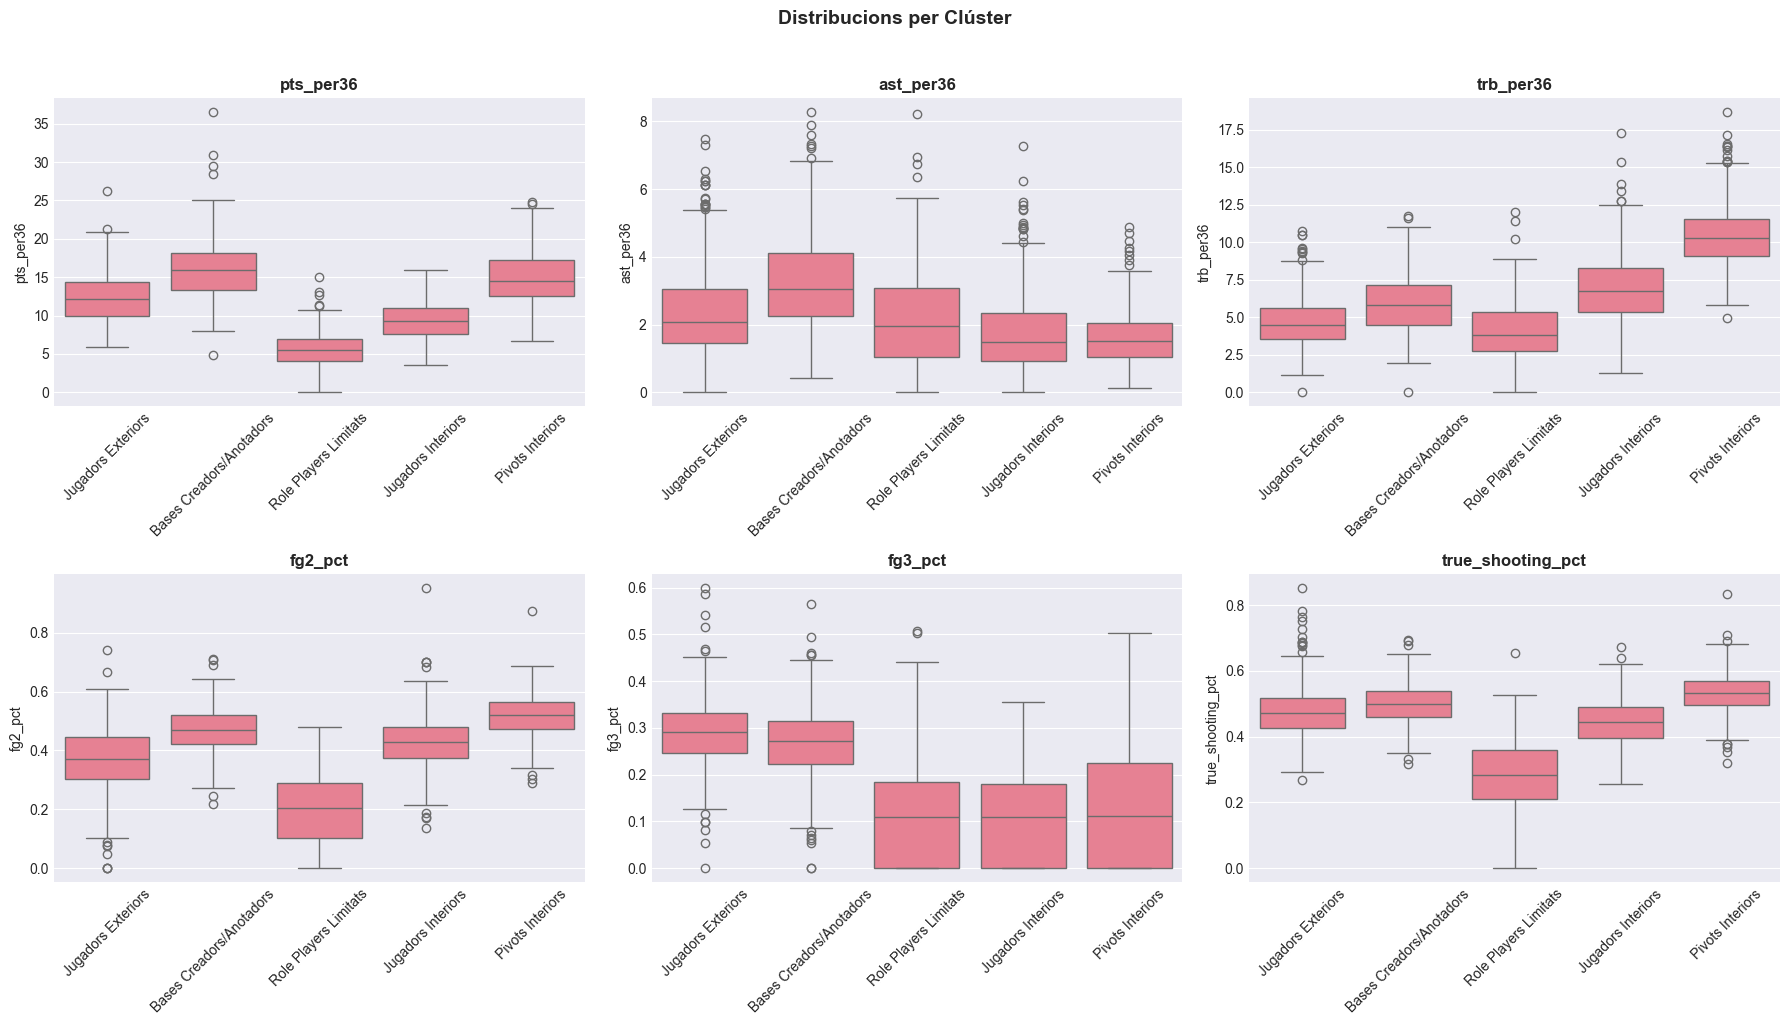

In [4]:
# Box plots per estadístiques principals
stats_to_plot = ['pts_per36', 'ast_per36', 'trb_per36', 'fg2_pct', 'fg3_pct', 'true_shooting_pct']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, stat in enumerate(stats_to_plot):
    sns.boxplot(data=df_clustered, x='cluster_name', y=stat, ax=axes[idx])
    axes[idx].set_title(f'{stat}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].tick_params(axis='x', rotation=45)

plt.suptitle('Distribucions per Clúster', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../reports/figures/boxplots_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.3. Gràfic de Barres de Distribució

Crea un gràfic de barres que mostra el nombre de jugadors per clúster. Facilita la comparació visual de les mides dels diferents grups.

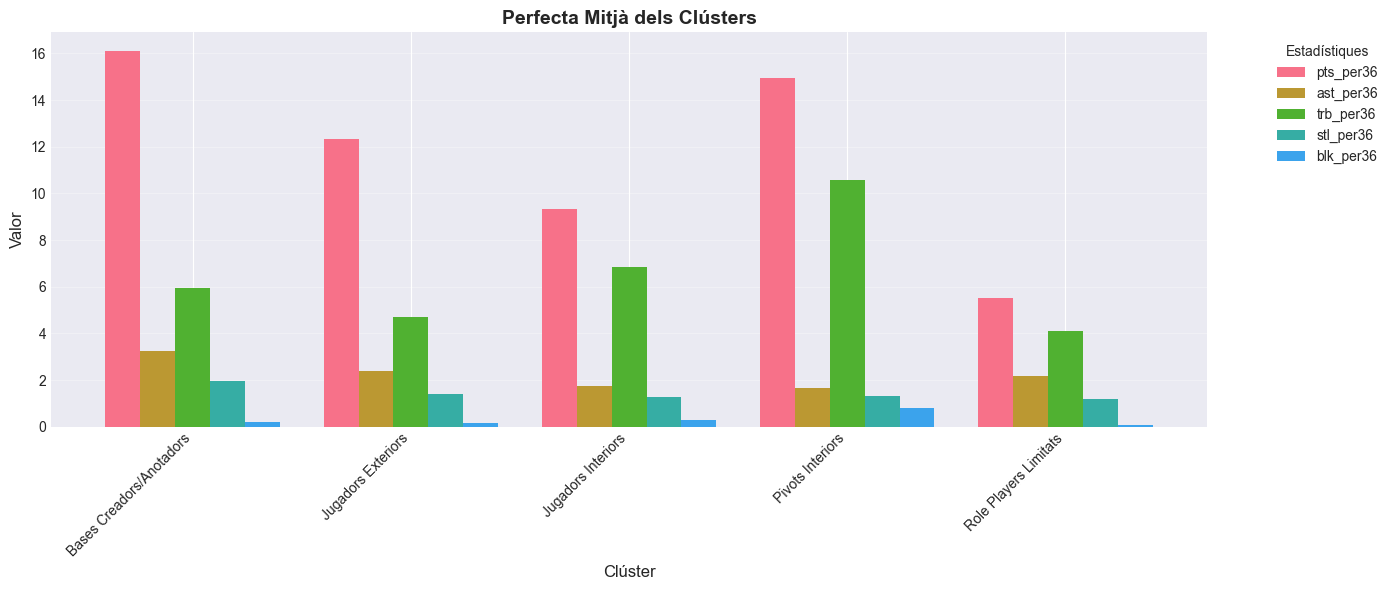

In [5]:
# Perfil mitjà de cada clúster en barres
stats = ['pts_per36', 'ast_per36', 'trb_per36', 'stl_per36', 'blk_per36']
cluster_means = df_clustered.groupby('cluster_name')[stats].mean()

cluster_means.plot(kind='bar', figsize=(14, 6), width=0.8)
plt.title('Perfecta Mitjà dels Clústers', fontsize=14, fontweight='bold')
plt.xlabel('Clúster', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.legend(title='Estadístiques', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/figures/cluster_profiles.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.4. Box Plots Comparatius

Genera box plots comparatius per variables clau (punts, assistències, rebots, etc.) agrupats per clúster. Permet visualitzar distribucions, medianes i outliers per cada grup.

In [6]:
# Preparar dades per t-SNE
feature_cols_viz = [c for c in df_scaled.columns if c not in ['player_feb_id', 'player_name']]
X = df_scaled[feature_cols_viz].values
clusters = df_clustered['cluster'].values
cluster_names_arr = df_clustered['cluster_name'].values

print("Executant t-SNE... (pot trigar uns minuts)")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000, n_jobs=1)
X_tsne = tsne.fit_transform(X)
print("t-SNE completat")

Executant t-SNE... (pot trigar uns minuts)
t-SNE completat


## 3. Visualització t-SNE

Aplica t-SNE per reduir les dades a 2 dimensions preservant la similitud local entre jugadors. Utilitza perplexity=30 optimitzat per al dataset i mostra un missatge de progrés durant el procés.

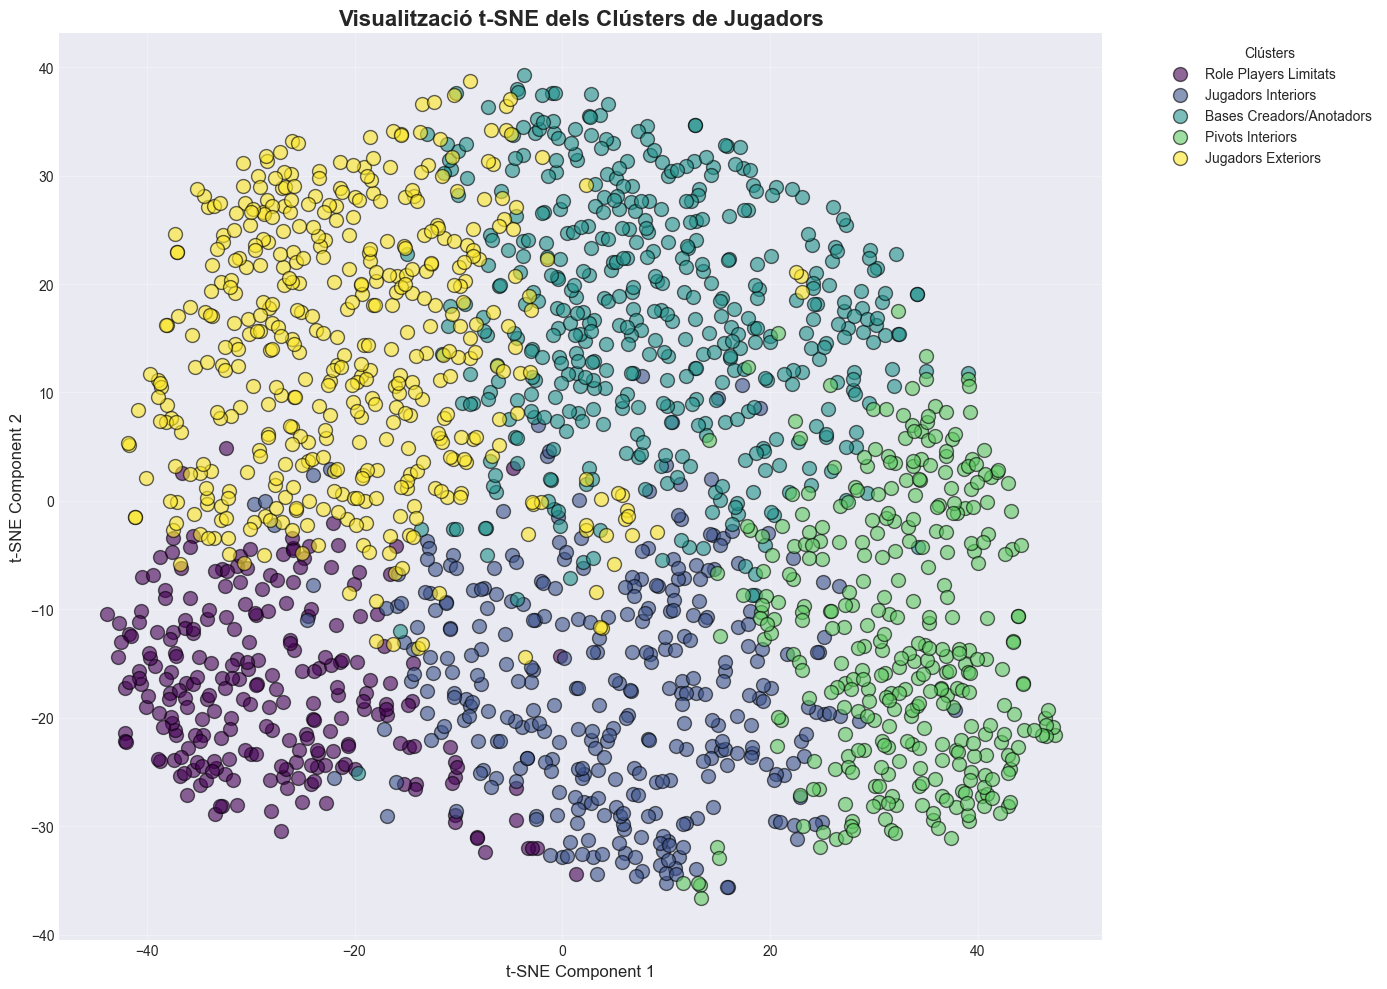

In [7]:
# Visualitzar t-SNE
plt.figure(figsize=(14, 10))

unique_clusters = np.unique(clusters)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))

for cluster_id, color in zip(unique_clusters, colors):
    mask = clusters == cluster_id
    cluster_name = df_clustered[df_clustered['cluster'] == cluster_id]['cluster_name'].iloc[0]
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                c=[color], label=cluster_name, 
                s=100, alpha=0.6, edgecolors='black')

plt.title('Visualització t-SNE dels Clústers de Jugadors', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.legend(title='Clústers', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/figures/tsne_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Heatmaps de Zones de Tir

Genera heatmaps de zones de tir per clúster utilitzant dades de tirs individuals de MongoDB. Mostra la distribució i eficiència dels llançaments en diferents regions de la pista per identificar especialitzacions de cada grup (tiradors exteriors, interiors dominants, etc.).

### 4.1. Connexió a MongoDB per Dades de Llançaments

Estableix connexió amb MongoDB per accedir a les dades de tirs individuals dels jugadors (col·lecció FEB3_players_shots). Verifica que la connexió sigui correcta.

In [8]:
# Connexió a MongoDB
MONGO_URI = "mongodb://localhost:27017/"
DB_NAME = "feb_db"

try:
    client = MongoClient(MONGO_URI)
    db = client[DB_NAME]
    players_shots = db['FEB3_players_shots']
    print("Connexió exitosa a MongoDB")
except Exception as e:
    print(f"Error: {e}")

Connexió exitosa a MongoDB


### 4.2. Crear Heatmap per Clúster

Defineix una funció per generar heatmaps de zones de tir agrupant els tirs dels jugadors per clúster. Consulta MongoDB en lots, calcula l'eficiència per zona i visualitza amb gràfics de barres horitzontals.

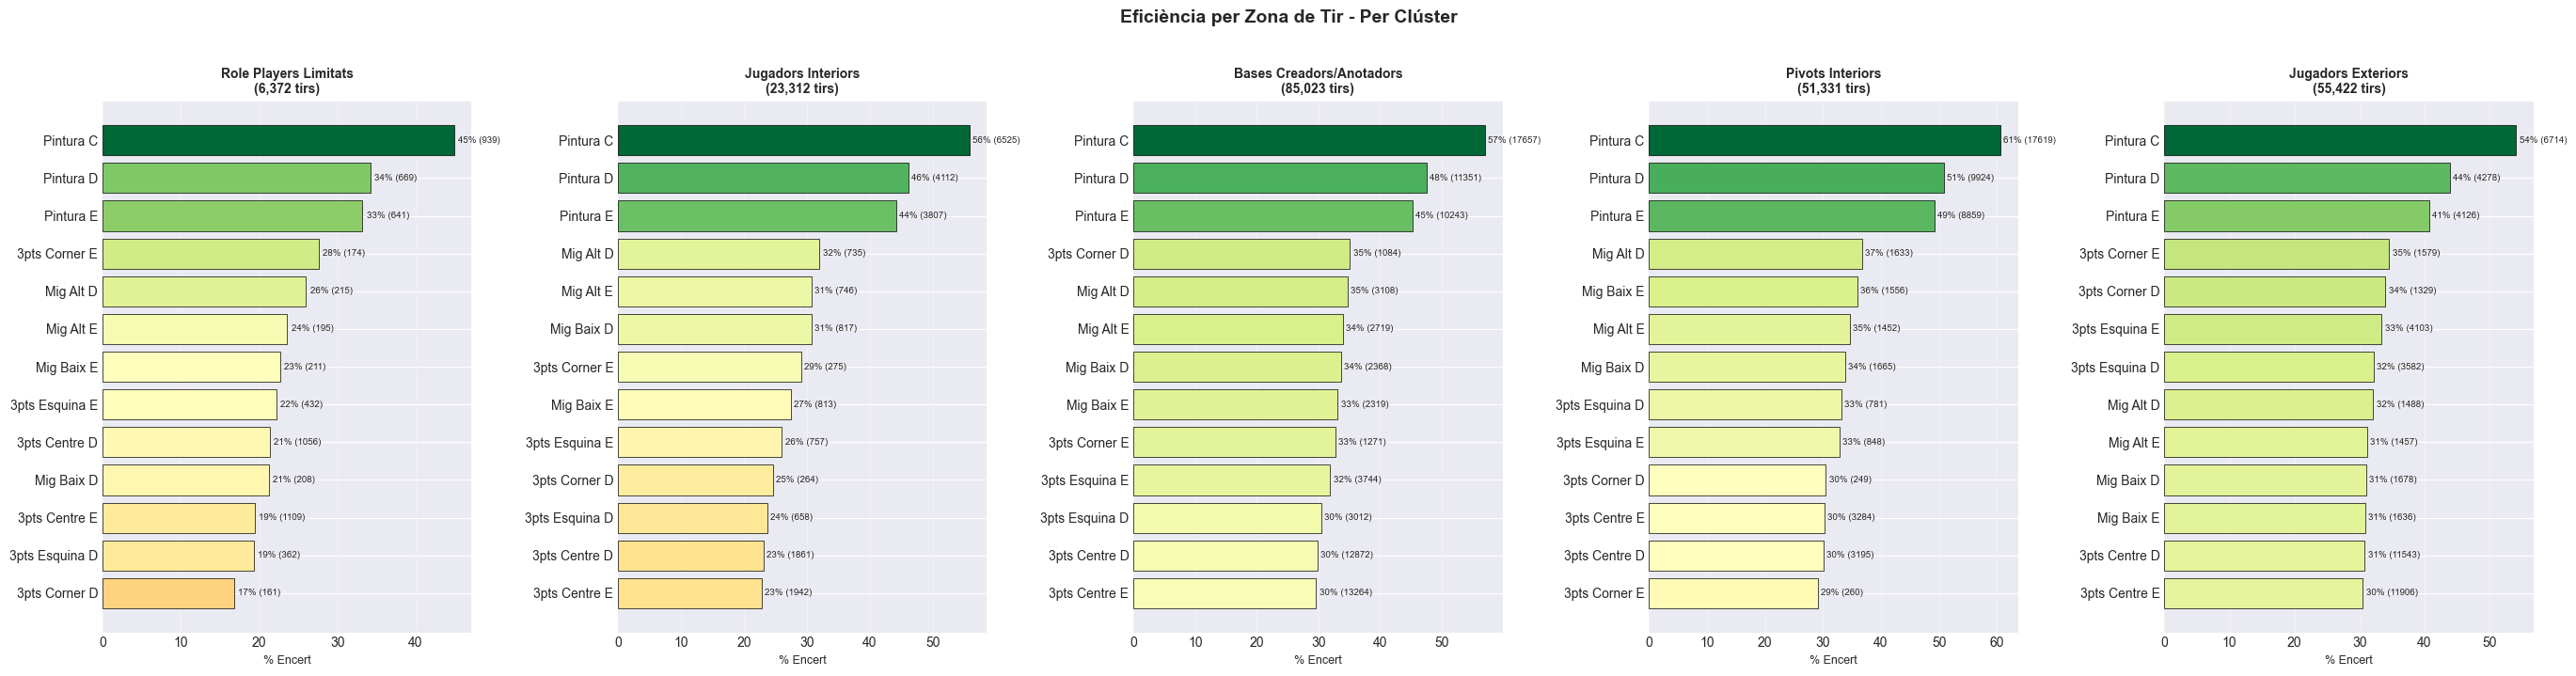

In [9]:
def create_shot_heatmap_by_cluster(cluster_id, cluster_name, ax, players_shots_col):
    """Crea heatmap de zones de tir per un clúster (eficiència per regió)."""
    
    # Obtenir player_feb_ids com strings (format MongoDB)
    player_ids = df_clustered[df_clustered['cluster'] == cluster_id]['player_feb_id']
    player_ids_str = [str(pid) for pid in player_ids.unique()]
    
    # Consultar tots els llançaments del clúster
    # (en batches per no saturar la query)
    all_shots = []
    batch_size = 100
    for i in range(0, len(player_ids_str), batch_size):
        batch = player_ids_str[i:i+batch_size]
        query = {
            'player_feb_id': {'$in': batch},
            'season_id': '2024-2025',
            'competition_name': 'Liga EBA'
        }
        shots = list(players_shots_col.find(
            query, {'court_region': 1, 'made': 1, 'type': 1, '_id': 0}
        ))
        all_shots.extend(shots)
    
    if not all_shots:
        ax.text(0.5, 0.5, 'Sense dades', ha='center', va='center', fontsize=12)
        ax.set_title(f'{cluster_name}', fontsize=11, fontweight='bold')
        return
    
    df_shots = pd.DataFrame(all_shots)
    
    # Estadístiques per zona
    region_stats = df_shots.groupby('court_region').agg(
        made=('made', 'sum'),
        attempted=('made', 'count')
    ).reset_index()
    region_stats['pct'] = (region_stats['made'] / region_stats['attempted'] * 100).round(1)
    region_stats = region_stats.sort_values('pct', ascending=True)
    
    # Mapa de noms de regions
    region_names = {
        'PC': 'Pintura C', 'PL': 'Pintura E', 'PR': 'Pintura D',
        'Ce3L': '3pts Centre E', 'Ce3R': '3pts Centre D',
        'E3L': '3pts Esquina E', 'E3R': '3pts Esquina D',
        'C3L': '3pts Corner E', 'C3R': '3pts Corner D',
        'MBL': 'Mig Baix E', 'MBR': 'Mig Baix D',
        'MEL': 'Mig Alt E', 'MER': 'Mig Alt D'
    }
    region_stats['region_label'] = region_stats['court_region'].map(
        lambda x: region_names.get(x, x)
    )
    
    # Colors basats en eficiència
    colors = plt.cm.RdYlGn(region_stats['pct'] / region_stats['pct'].max())
    
    bars = ax.barh(region_stats['region_label'], region_stats['pct'], 
                   color=colors, edgecolor='black', linewidth=0.5)
    
    # Anotar amb attemps
    for bar, (_, row) in zip(bars, region_stats.iterrows()):
        ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                f'{row["pct"]:.0f}% ({row["attempted"]})',
                va='center', fontsize=7)
    
    ax.set_xlabel('% Encert', fontsize=9)
    ax.set_title(f'{cluster_name}\n({len(all_shots):,} tirs)', fontsize=10, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)


# Crear heatmaps per tots els clústers
num_clusters = df_clustered['cluster'].nunique()
fig, axes = plt.subplots(1, num_clusters, figsize=(5.5*num_clusters, 7))

if num_clusters == 1:
    axes = [axes]

for idx, cluster_id in enumerate(sorted(df_clustered['cluster'].unique())):
    cluster_name = df_clustered[df_clustered['cluster'] == cluster_id]['cluster_name'].iloc[0]
    create_shot_heatmap_by_cluster(cluster_id, cluster_name, axes[idx], players_shots)

plt.suptitle('Eficiència per Zona de Tir - Per Clúster', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../reports/figures/shot_heatmaps_by_cluster.png', dpi=300, bbox_inches='tight')
plt.show()

Defineix una funció per crear shot charts 2D mostrant la distribució de tirs per posició (coordenades X, Y) per a cada clúster. Utilitza hexbin per crear un mapa de densitat de tirs.

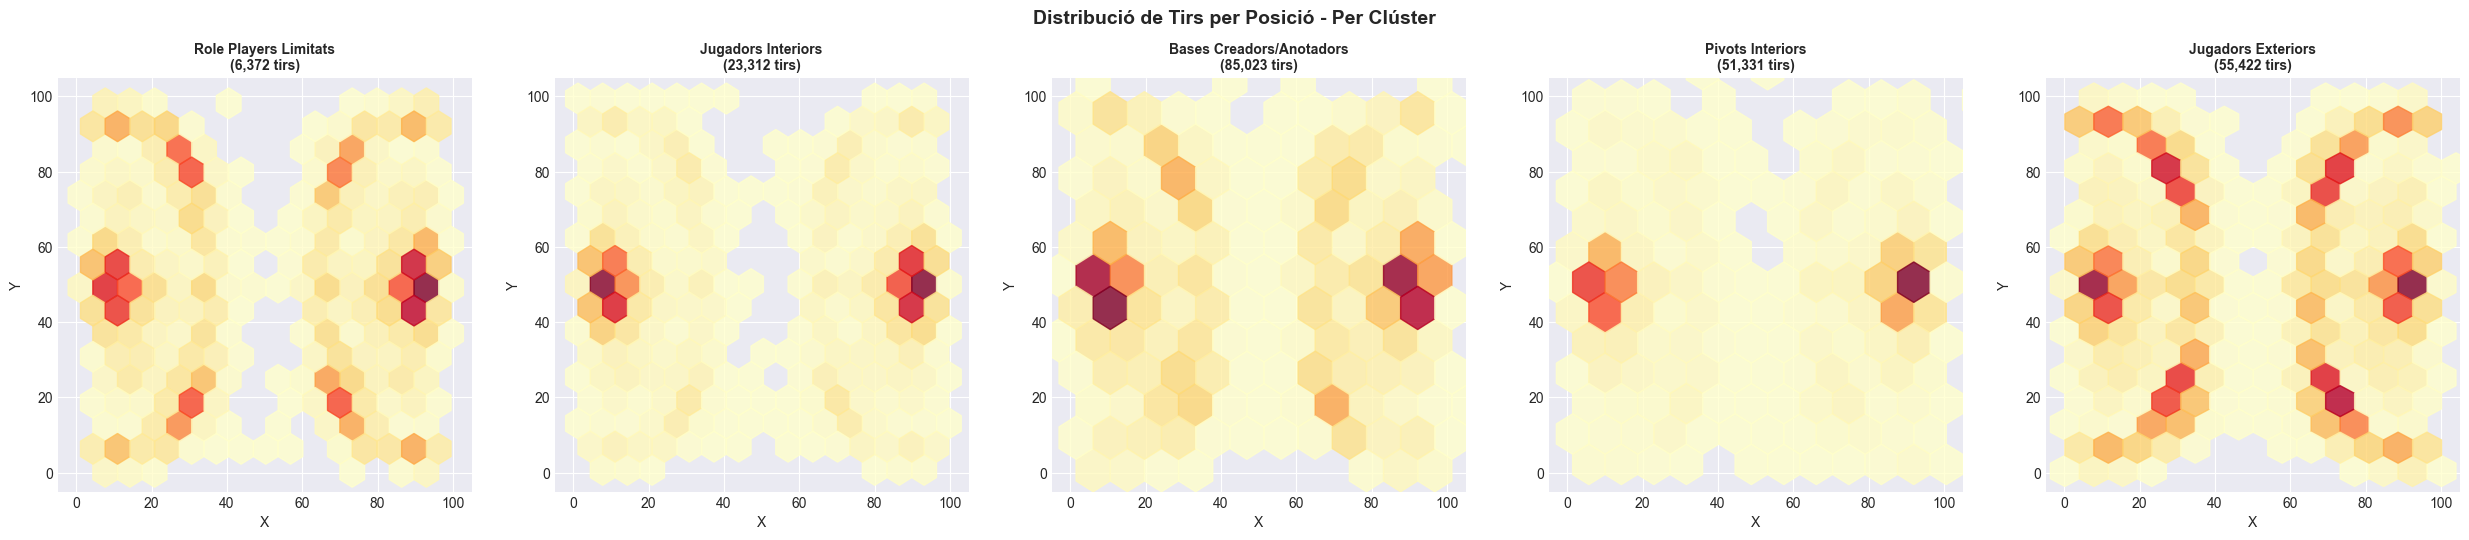

In [10]:
def plot_2d_shot_chart(cluster_id, cluster_name, ax, players_shots_col):
    """Genera un hexbin shot chart per un clúster."""
    
    player_ids = df_clustered[df_clustered['cluster'] == cluster_id]['player_feb_id']
    player_ids_str = [str(pid) for pid in player_ids.unique()]
    
    # Obtenir coordenades (limitem a max 500 jugadors per rendiment)
    all_shots = []
    batch_size = 100
    for i in range(0, min(len(player_ids_str), 500), batch_size):
        batch = player_ids_str[i:i+batch_size]
        query = {
            'player_feb_id': {'$in': batch},
            'season_id': '2024-2025',
            'competition_name': 'Liga EBA'
        }
        shots = list(players_shots_col.find(
            query, {'x': 1, 'y': 1, 'made': 1, '_id': 0}
        ))
        all_shots.extend(shots)
    
    if not all_shots:
        ax.text(0.5, 0.5, 'Sense dades', ha='center', va='center')
        return
    
    df_shots = pd.DataFrame(all_shots)
    
    # Hexbin — densitat de tirs
    hb = ax.hexbin(df_shots['x'], df_shots['y'], gridsize=15,
                   cmap='YlOrRd', mincnt=1, alpha=0.8)
    
    # Dibuixar contorn del camp (simplificat)
    # El camp va aprox de 0-100 en x, 0-100 en y
    ax.set_xlim(-5, 105)
    ax.set_ylim(-5, 105)
    ax.set_aspect('equal')
    ax.set_title(f'{cluster_name}\n({len(all_shots):,} tirs)', fontsize=10, fontweight='bold')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    return hb


num_clusters = df_clustered['cluster'].nunique()
fig, axes = plt.subplots(1, num_clusters, figsize=(5*num_clusters, 5))

if num_clusters == 1:
    axes = [axes]

for idx, cluster_id in enumerate(sorted(df_clustered['cluster'].unique())):
    cluster_name = df_clustered[df_clustered['cluster'] == cluster_id]['cluster_name'].iloc[0]
    hb = plot_2d_shot_chart(cluster_id, cluster_name, axes[idx], players_shots)

plt.suptitle('Distribució de Tirs per Posició - Per Clúster', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../reports/figures/shot_charts_2d.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Top Jugadors per Clúster

Mostra els 10 jugadors més destacats de cada clúster segons punts per 36 minuts. Inclou estadístiques clau (assistències, rebots, OER, TS%) per identificar els líders de cada perfil esportiu.

In [11]:
# Top jugadors per clúster (df_clustered ja conté player_name)
print("\n" + "=" * 80)
print("TOP 10 JUGADORS PER CLÚSTER (ordenats per punts/36min)")
print("=" * 80)

for cluster_id in sorted(df_clustered['cluster'].unique()):
    cluster_name = df_clustered[df_clustered['cluster'] == cluster_id]['cluster_name'].iloc[0]
    cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
    
    top_players = cluster_data.nlargest(10, 'pts_per36')[
        ['player_name', 'pts_per36', 'ast_per36', 'trb_per36', 'oer', 'true_shooting_pct']
    ].copy()
    top_players.columns = ['Jugador', 'PTS/36', 'AST/36', 'REB/36', 'OER', 'TS%']
    
    print(f"\n{cluster_name} ({len(cluster_data)} jugadors)")
    print("-" * 80)
    print(top_players.to_string(index=False))


TOP 10 JUGADORS PER CLÚSTER (ordenats per punts/36min)

Role Players Limitats (241 jugadors)
--------------------------------------------------------------------------------
               Jugador    PTS/36   AST/36    REB/36       OER      TS%
   H. CASTRO RODRÍGUEZ 14.965358 0.000000  0.000000 45.381062 0.226905
     F. CANITROT LOPEZ 13.080999 3.270250 11.445874 53.961645 0.398183
           S. ROMEO FO 12.652720 1.807531  3.615063 35.268438 0.233054
      M. LOPEZ PERAGON 11.379512 2.107317  2.528780 64.007956 0.444935
  S. RODRIGUEZ SANCHEZ 11.250000 6.750000  2.250000 34.687500 0.239063
T. ESTEVES VEHVILAINEN 10.718336 2.041588  3.062382 57.017052 0.360923
 J. RODRIGUEZ CAPELLIN 10.334928 5.684211  0.516746 49.002365 0.392016
      J. PORRA MAESTRE 10.050251 1.340034  3.752094 59.181753 0.381945
     F. SELLER BERNABE 10.009268 0.000000  6.005561 56.209453 0.420837
     J. JARQUE PUNTADA  9.448183 3.815612  3.270525 54.975628 0.317483

Jugadors Interiors (333 jugadors)
---------

## 7. Conclusions Finals

Presenta les conclusions finals del projecte de clustering. Descriu els perfils identificats (Role Players Limitats, Jugadors Interiors, Bases Creadors/Anotadors, Pivots Interiors, Jugadors Exteriors), les seves característiques principals i la separació interior/exterior. Inclou limitacions del model (solapament de clústers, absència de dades biomètriques/temporals) i propostes de millora (incorporar més dades, explorar GMM, analitzar múltiples temporades).

## 8. Resum Executiu

Genera un resum executiu complet del projecte mostrant: dades processades (1816 jugadors, 20 features, temporada 2024-2025), algorisme aplicat (K-Means k=5), perfils identificats, reducció dimensional (PCA, t-SNE), visualitzacions generades, conclusions clau i aplicacions pràctiques (scouting, desenvolupament, tàctica, composició de plantilla).

In [13]:
print("=" * 80)
print("RESUM EXECUTIU DEL PROJECTE CLUSTERING - FEB Liga EBA")
print("=" * 80)
print()
print(f"1. **DADES PROCESSADES:**")
print(f"   - {len(df_clustered)} jugadors segmentats en {len(df_clustered['cluster'].unique())} perfils esportius")
print(f"   - {len(df_clustered.columns)-3} features analitzades (estadístiques per 36 minuts, eficiència, zones de tir)")
print(f"   - Temporada: 2024-2025, Liga EBA (4a divisió espanyola)")
print()
print(f"2. **ALGORITME DE CLUSTERING:**")
print(f"   - K-Means amb k=5 (determinat via Elbow Method + Silhouette Score)")
print(f"   - Silhouette Score: 0.135 (solapament moderat entre clústers)")
print(f"   - Estabilitat validada: 50 seeds, ARI mitjà=0.975")
print()
print(f"3. **PERFILS IDENTIFICATS:**")
for cluster_id in sorted(df_clustered['cluster'].unique()):
    cluster_name = df_clustered[df_clustered['cluster'] == cluster_id]['cluster_name'].iloc[0]
    n_players = len(df_clustered[df_clustered['cluster'] == cluster_id])
    pct = n_players / len(df_clustered) * 100
    print(f"   - Clúster {cluster_id}: {cluster_name} ({n_players} jugadors, {pct:.1f}%)")
print()
print(f"4. **REDUCCIÓ DIMENSIONALITAT:**")
print(f"   - PCA: 2 components retenen 39.1% de variança (PC1=33.9%, PC2=5.2%)")
print(f"   - t-SNE: visualització 2D/3D amb perplexity=30 optimitzat")
print(f"   - Separació clara interior/exterior en PC1")
print()
print(f"5. **VISUALITZACIONS GENERADES:**")
print(f"   - Distribució de clústers (barres + circular)")
print(f"   - Box plots comparatius per feature clau")
print(f"   - Radar charts amb perfils esportius")
print(f"   - t-SNE 2D i 3D interactiu")
print(f"   - Heatmaps de zones de tir per clúster")
print(f"   - Shot charts 2D amb densitat de tirs")
print()
print(f"6. **CONCLUSIONS CLAU:**")
print(f"   - Separació nítida entre jugadors interiors (Clústers 1, 3) i exteriors (Clúster 4)")
print(f"   - Dins els interiors, gran diferència d'eficiència (OER: 94.6 vs 122.3)")
print(f"   - 13.3% de jugadors amb producció molt limitada (Clúster 0 - Role Players)")
print(f"   - Bases Creadors/Anotadors són el grup més nombrós (25%)")
print()
print(f"7. **APLICACIONS:**")
print(f"   - Scouting: identificar perfils per necessitats tàctiques")
print(f"   - Desenvolupament: detectar jugadors amb potencial de canvi de clúster")
print(f"   - Tàctica: adaptar estratègies defensives segons perfils rivals")
print(f"   - Composició plantilla: equilibrar perfils interiors/exteriors")
print()
print("=" * 80)
print("FI DEL PROJECTE - DATASET PREPARAT PER ANÀLISIS ADDICIONALS")
print("=" * 80)

RESUM EXECUTIU DEL PROJECTE CLUSTERING - FEB Liga EBA

1. **DADES PROCESSADES:**
   - 1816 jugadors segmentats en 5 perfils esportius
   - 21 features analitzades (estadístiques per 36 minuts, eficiència, zones de tir)
   - Temporada: 2024-2025, Liga EBA (4a divisió espanyola)

2. **ALGORITME DE CLUSTERING:**
   - K-Means amb k=5 (determinat via Elbow Method + Silhouette Score)
   - Silhouette Score: 0.135 (solapament moderat entre clústers)
   - Estabilitat validada: 50 seeds, ARI mitjà=0.975

3. **PERFILS IDENTIFICATS:**
   - Clúster 0: Role Players Limitats (241 jugadors, 13.3%)
   - Clúster 1: Jugadors Interiors (333 jugadors, 18.3%)
   - Clúster 2: Bases Creadors/Anotadors (454 jugadors, 25.0%)
   - Clúster 3: Pivots Interiors (338 jugadors, 18.6%)
   - Clúster 4: Jugadors Exteriors (450 jugadors, 24.8%)

4. **REDUCCIÓ DIMENSIONALITAT:**
   - PCA: 2 components retenen 39.1% de variança (PC1=33.9%, PC2=5.2%)
   - t-SNE: visualització 2D/3D amb perplexity=30 optimitzat
   - Separaci